In [28]:
import pandas as pd
df = pd.read_csv("IMDB Dataset.csv")
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [29]:
# Check the dataset size (rows, columns)
df.shape  

# Display the column names
df.columns  

# Check the distribution of sentiments (positive vs negative)
df['sentiment'].value_counts()

# Create a new column for review length (number of words in each review)
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

# Get summary statistics of review lengths
df['review_length'].describe()


count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: review_length, dtype: float64

In [30]:
import re
import string
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text(text, remove_stopwords=True, do_stem=True, do_lemmatize=True):
    # 1. Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # 2. Lowercase
    text = text.lower()
    
    # 3. Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    
    # 4. Remove numbers
    text = re.sub(r"\d+", " ", text)
    
    # 5. Remove extra whitespaces
    text = re.sub(r"\s+", " ", text).strip()
    
    # 6. Tokenize
    words = text.split()
    
    # 7. Remove stopwords
    if remove_stopwords:
        words = [w for w in words if w not in stop_words]
    
    # 8. Stemming (before lemmatization)
    if do_stem:
        words = [stemmer.stem(w) for w in words]
    
    # 9. Lemmatization
    if do_lemmatize:
        words = [lemmatizer.lemmatize(w) for w in words]
    
    return " ".join(words)

# Apply preprocessing
df['clean_review'] = df['review'].apply(preprocess_text)
df[['review', 'clean_review']].head()


C:\Users\PC\AppData\Local\Temp\ipykernel_30320\2764411215.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


,review,clean_review
0,One of the other reviewers has mentioned that ...,one review mention watch oz episod hook right ...
1,A wonderful little production. <br /><br />The...,wonder littl product film techniqu unassum old...
2,I thought this was a wonderful way to spend ti...,thought wonder way spend time hot summer weeke...
3,Basically there's a family where a little boy ...,basic famili littl boy jake think zombi closet...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love time money visual stun film...


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))  

# Fit & transform on clean reviews
X = tfidf.fit_transform(df['clean_review'])
y = df['sentiment']

print("Shape of feature matrix:", X.shape)


Shape of feature matrix: (50000, 10000)


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)


(40000, 10000) (10000, 10000)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize Logistic Regression
log_reg = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)


y_test_pred = log_reg.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))


Train Accuracy: 0.922575
Test Accuracy: 0.8947

Classification Report (Test):
               precision    recall  f1-score   support

    negative       0.90      0.89      0.89      5000
    positive       0.89      0.90      0.90      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [34]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Build improved model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.6),  # Increased dropout
    Dense(64, activation='relu'),
    Dropout(0.6),  # Increased dropout
    Dense(1, activation='sigmoid')
])

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Convert labels to binary (0/1)
y_train_bin = (y_train == "positive").astype(int)
y_test_bin = (y_test == "positive").astype(int)

# Early stopping callback
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train
history = model.fit(X_train.toarray(), y_train_bin,
                    validation_data=(X_test.toarray(), y_test_bin),
                    epochs=10,
                    batch_size=128,
                    callbacks=[es],
                    verbose=1)

# Evaluate
train_acc = model.evaluate(X_train.toarray(), y_train_bin, verbose=0)[1]
test_acc = model.evaluate(X_test.toarray(), y_test_bin, verbose=0)[1]

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)


d:\miniconda\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7585 - loss: 0.5000 - val_accuracy: 0.8971 - val_loss: 0.2504
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9217 - loss: 0.2125 - val_accuracy: 0.8974 - val_loss: 0.2556
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9442 - loss: 0.1592 - val_accuracy: 0.8943 - val_loss: 0.2741
Train Accuracy: 0.9324250221252441
Test Accuracy: 0.8970999717712402


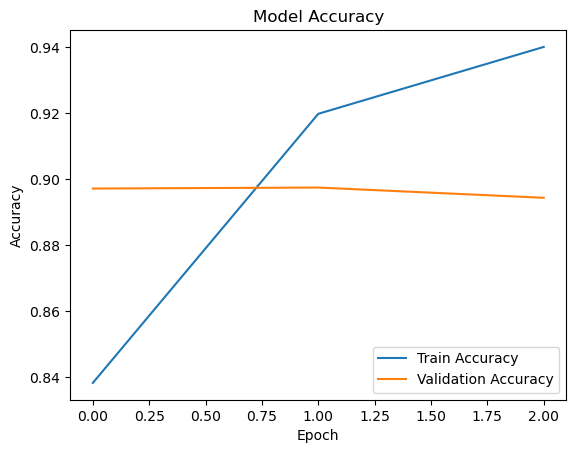

In [35]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
